In [3]:
import tensorflow_datasets as tfds

ds, info = tfds.load("reddit", split="train", with_info=True, data_dir="~/shared/ml/tensorflow")

# Take the first five rows
first_five_rows = ds.take(5)

# Iterate over the first five rows and print them
for row in first_five_rows:
    print(row)

{'author': <tf.Tensor: shape=(), dtype=string, numpy=b'huh7'>, 'body': <tf.Tensor: shape=(), dtype=string, numpy=b"I  was talking to this girl I've met today, and I'm not so sure what happened. It was nice seeing her after almost 3 weeks last talking with her, and she seems like a cool person to hang out with. I realized however, that I want to try to be good friends with her. We walked around and talked a while, and before I knew what happened I asked and she gave me her digits. \n\nWe proceeded to text each other back and forth about lots of bullshit, and I suddenly asked myself; is this emotionally cheating? To be honest, I do feel as if I did. \n\nI understand I (19M)am in a monogamous relationship with my gf(17), and I want communication between us to be crystal clear. I feel guilty, and an obligation to tell her of what I did. Should I tell my gf about this, or stop myself in the future before something like this happens again? I am emotionally confused right now, and could use s

In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pandas as pd

conf = SparkConf().set("spark.jars.packages", "com.linkedin.sparktfrecord:spark-tfrecord_2.12:0.6.0")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
print(f'The PySpark {spark.version} version is running...')

:: loading settings :: url = jar:file:/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
com.linkedin.sparktfrecord#spark-tfrecord_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ac09366f-7ffb-4dcc-b436-d71d78350072;1.0
	confs: [default]
	found com.linkedin.sparktfrecord#spark-tfrecord_2.12;0.6.0 in central
:: resolution report :: resolve 252ms :: artifacts dl 5ms
	:: modules in use:
	com.linkedin.sparktfrecord#spark-tfrecord_2.12;0.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark

The PySpark 3.5.0 version is running...


In [2]:
# Directory containing TFRecord files and the JSON file
tfrecord_dir = "shared/ml/tensorflow/reddit/1.0.0/*"

reddit_data = spark.read.format("tfrecord") \
    .option("recordType", "Example") \
    .option("pathGlobFilter", "*.tfrecord-*") \
    .load(tfrecord_dir)


# reddit_data.show(3)

# EXPLORATORY DATA ANALYSIS
### First we do Exploratory Data Analysis to better understand the trends in the underlying data.

### The below code cell prints the total number of data points in our reddit data. We see that we have almost 4 million rows in our dataset.

In [10]:
reddit_data.count()

3848330

### Next, we print the count of posts in each subreddit. We see that the subreddit 'AskReddit' has the maximum number of posts.

In [4]:
# Getting number of texts per subreddit
summary_per_subreddit = reddit_data.groupby("subreddit").count().orderBy(col('count').desc())
summary_per_subreddit.show()

+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
|           politics| 36518|
|               pics| 35098|
|                sex| 28806|
|                WTF| 25781|
|  explainlikeimfive| 25482|
|      todayilearned| 25004|
|            Fitness| 22694|
|               IAmA| 22689|
|          worldnews| 22577|
|              DotA2| 22405|
+-------------------+------+
only showing top 20 rows



### In order to visualize better let's plot a barchart showing the average post length of posts in each subreddit.

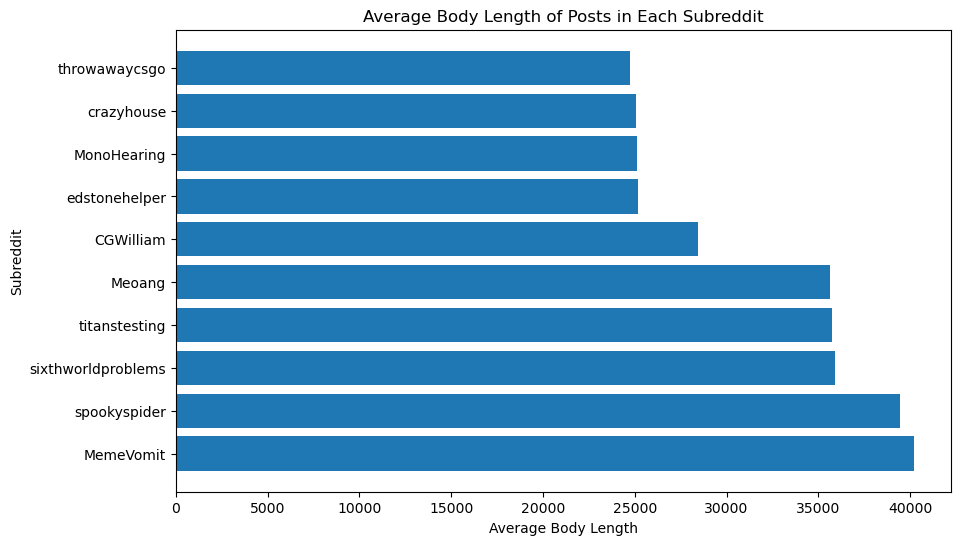

In [5]:
# Text Length Analysis
reddit_data = reddit_data.withColumn('body_length', length(reddit_data['body']))

avg_body_length = reddit_data.select(['subreddit', 'body_length']) \
                             .groupBy('subreddit') \
                             .avg('body_length') \
                             .withColumnRenamed('avg(body_length)', 'average_body_length')

# Sorting the results in descending order of average body length
avg_body_length_sorted = avg_body_length.orderBy(col('average_body_length').desc())

# Showing the results
avg_body_length_sorted_pd = avg_body_length_sorted.limit(10).toPandas()

# Setting the size of the plot
plt.figure(figsize=(10, 6))

# Creating a horizontal bar plot
plt.barh(avg_body_length_sorted_pd['subreddit'], avg_body_length_sorted_pd['average_body_length'])

# Adding titles and labels
plt.xlabel('Average Post Length')
plt.ylabel('Subreddit')
plt.title('Average Post Length of Posts in Each Subreddit')

# Display the plot
plt.show()

### Let's plot a barchart showing the Top 10 Authors by Number of Posts.
* Note: We notice that '[deleted]' has the most number of posts, which means most users have deleted their usernames. So while plotting the barplot we ignore that for better visualization.

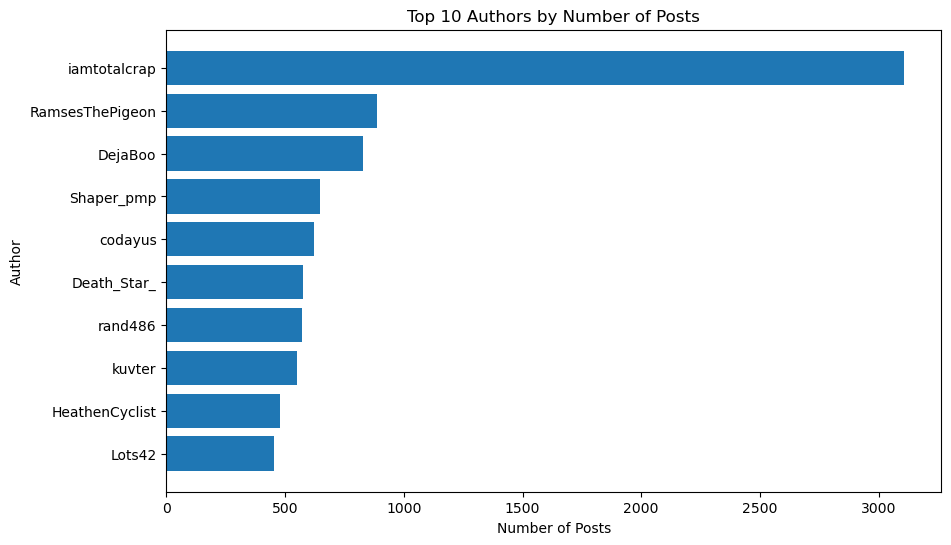

In [9]:
# Top Authors
top_authors = reddit_data.groupBy('author').count().orderBy('count', ascending=False)

# Convert the result to a Pandas DataFrame
top_authors_pd = top_authors.limit(11).toPandas()

# Skip the first data point because it's "[deleted]"
top_authors_pd = top_authors_pd.iloc[1:]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_authors_pd['author'], top_authors_pd['count'])

# Invert y-axis to have the author with the most posts on top
plt.gca().invert_yaxis()

# Add labels and title
plt.xlabel('Number of Posts')
plt.ylabel('Author')
plt.title('Top 10 Authors by Number of Posts')

# Display the plot
plt.show()

In [5]:
from textblob import TextBlob

# Define a Pandas UDF for sentiment analysis
@pandas_udf(DoubleType())
def sentiment_analysis_pandas_udf(content: pd.Series) -> pd.Series:
    return content.apply(lambda text: TextBlob(text).sentiment.polarity)

# Apply the Pandas UDF on the DataFrame
reddit_data_with_sentiment = reddit_data.withColumn('sentiment', sentiment_analysis_pandas_udf(col('body')))

In [ ]:
# Categorizing sentiment
reddit_data_with_sentiment = reddit_data_with_sentiment.withColumn(
    'sentiment_category',
    when(col('sentiment') < 0, 'Negative')
    .when(col('sentiment') == 0, 'Neutral')
    .otherwise('Positive')
)

# Group by subreddit and sentiment category
sentiment_category_counts = reddit_data_with_sentiment.groupBy('subreddit', 'sentiment_category').count()

sentiment_category_counts_pd = sentiment_category_counts.toPandas()

# Pivot the DataFrame to get subreddits as index and categories as columns
pivot_df = sentiment_category_counts_pd.pivot(index='subreddit', columns='sentiment_category', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Sentiment Distribution in Each Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.legend(title='Sentiment Category')
plt.xticks(rotation=45)
plt.show()

/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/opt/conda/envs/bigdata/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/sql/pandas/serializers.py:224: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
